<a href="https://colab.research.google.com/github/elizabethyoo/team_9/blob/main/03_eda_unemployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Template

This is a template for the Group 9 analysis of small business during the Covid19 Pandemic. When starting a completely new analysis, please create a copy of this from the branch and rename it using analysis_name.ipynb format.

It will be updated with common functions.

#Setup

**Mount Google Drive**

To have access to the shared group 9 project folder, first create a shortcut to it in your drive. Then run the cell below to mount your google drive and follow the prompt to get the code.

In [ ]:
# Mount google drive

from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd



---



# Unemployment EDA

## Import Unemployment Dataset and States Key

These two keys are necessary to remap the variable values to something meaningful

In [ ]:
states = pd.read_csv('/content/gdrive/MyDrive/team_9/Datasets/state_key.csv', dtype={"ps_id":str})
state_key = {key:value for (key,value) in zip(states.ps_id,states.abrv)}
unemployment_key = {'3': 'unemployment_rate',
                '4': 'unemployment_count',
                '5': 'employment_count',
                '6': 'labor_force',
                '7': 'employment_ratio',
                '8': 'labor_participation_rate'}

Import the unemployment dataset

In [ ]:
df = pd.read_excel('/content/gdrive/MyDrive/team_9/Datasets/unemployment.xlsx')
df.head()

,Series ID,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,2021-07-01 00:00:00,2021-08-01 00:00:00
0,LASST010000000000003,2.7,2.6,2.6,13.2,7.9,7.7,7.4,7.1,6.7,4.7,4.7,4.7,4.3,4.0,3.8,3.6,3.4,3.3,3.2,3.1
1,LASST010000000000004,59405.0,58639.0,57895.0,288253.0,174680.0,171721.0,165510.0,156709.0,147334.0,107301.0,105558.0,106318.0,97725.0,91041.0,84716.0,79319.0,75398.0,73769.0,71678.0,69005.0
2,LASST010000000000005,2180872.0,2177852.0,2176275.0,1899019.0,2044109.0,2049715.0,2056348.0,2061877.0,2065378.0,2158999.0,2158343.0,2157736.0,2160236.0,2157723.0,2151242.0,2152641.0,2150324.0,2138949.0,2139008.0,2138677.0
3,LASST010000000000006,2240277.0,2236491.0,2234170.0,2187272.0,2218789.0,2221436.0,2221858.0,2218586.0,2212712.0,2266300.0,2263901.0,2264054.0,2257961.0,2248764.0,2235958.0,2231960.0,2225722.0,2212718.0,2210686.0,2207682.0
4,LASST010000000000007,56.3,56.2,56.1,49.0,52.7,52.8,53.0,53.1,53.2,55.6,55.5,55.5,55.5,55.5,55.3,55.3,55.2,54.9,54.9,54.8


The state and metric information is in the series ID. The code below seperates that string into meaningful variables and labels.

In [ ]:
# Extract the metric being measures
df['metric'] = [x[-1] for x in df['Series ID']]
df['metric'] = df['metric'].map(unemployment_key)

# Extract the state ID and convert to the state abbreviation
df['state'] = [x[5:7] for x in df['Series ID']]
df['state'] = df['state'].map(state_key)

# Select only the seasonally adjusted data
df['adjustment'] = [x.split("ST")[0] for x in df['Series ID']]
df = df.loc[df['adjustment'] == "LAU"].drop(columns = ['adjustment', 'Series ID'])

# Convert the dataset to long form so it can be merged with the main dataframe later
df = pd.melt(df, ['metric', 'state'])
df = df.rename(columns = {'variable': 'date', 'value': 'unemployment_rate'})

In [ ]:
df.head()

,metric,state,date,unemployment_rate
0,unemployment_rate,AL,2020-01-01,3.1
1,unemployment_count,AL,2020-01-01,69939.0
2,employment_count,AL,2020-01-01,2155478.0
3,labor_force,AL,2020-01-01,2225417.0
4,employment_ratio,AL,2020-01-01,55.6


## Plot unemployment rate by state from January 2020 to August 2021

In [ ]:
unemployment = df.loc[df['metric'] == "unemployment_rate"].drop(columns = 'metric').copy()
unemployment.head()

,state,date,unemployment_rate
0,AL,2020-01-01,3.1
7,AK,2020-01-01,5.4
14,AZ,2020-01-01,4.8
21,AR,2020-01-01,4.2
28,CA,2020-01-01,4.5


In [ ]:
# save the dataset
#unemployment.to_csv('/content/gdrive/MyDrive/team_9/Datasets/unemployment_cleaned.csv', index= False)

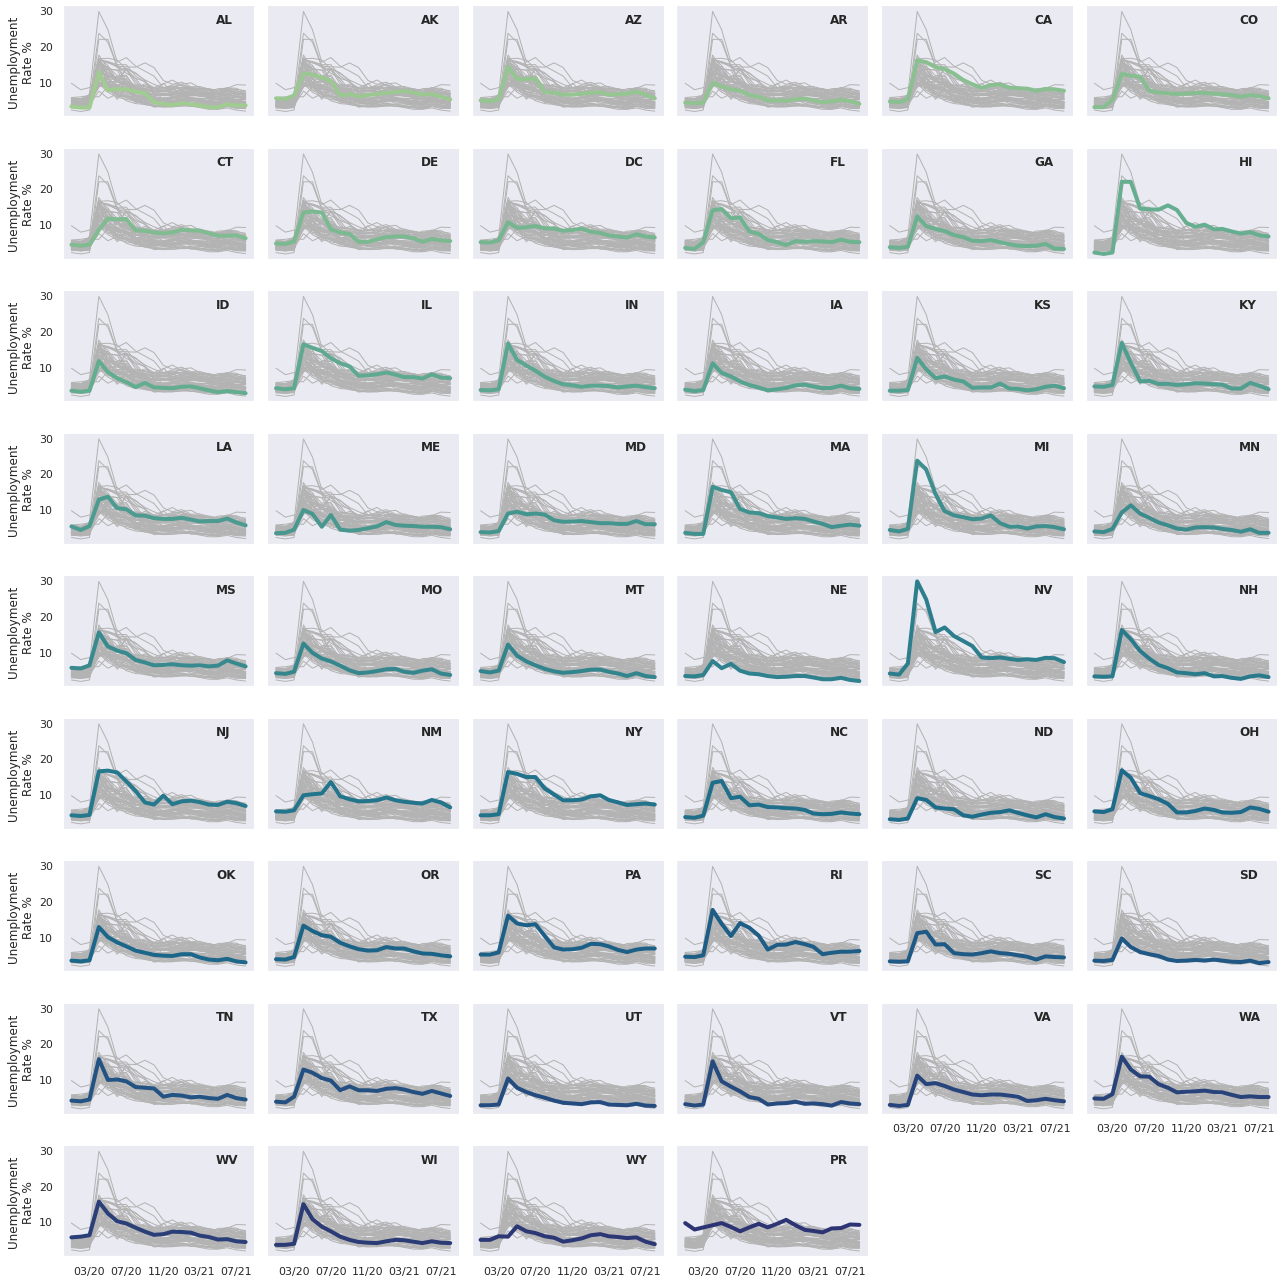

In [ ]:
sns.set_theme(style="dark")

# Plot each year's time series in its own facet
g = sns.relplot(
    data= unemployment,
    x="date", y="unemployment_rate", col="state", hue="state",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=6, height=2, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for state, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, state, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data= unemployment, x="date", y="unemployment_rate", units="state",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[1::2])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))


# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Unemployment\nRate %")
g.tight_layout()

## Pivot Table by State and Date

In [ ]:
df2 = df.pivot(index = ['state', 'date'], columns = 'info_id', values = 'value')
df2.head()
